In [1]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=882f5aa1f8a927ba2fb751d877ee3bd4a56361114382152ae168244183986fff
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [3]:
import chess
import chess.pgn
from chess import Board, Move
from enum import Enum
from google.colab import drive
import io
import itertools
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Iterator, List

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
GOOGL_DRIVE = "/content/drive/MyDrive/UNT/CSCE 5218/Semester Project"

In [6]:
all_games = pd.read_csv(f"{GOOGL_DRIVE}/data/all_games-10.28.2024.18.47.csv")

<ipython-input-6-3f3a425308e3>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  all_games = pd.read_csv(f"{GOOGL_DRIVE}/data/all_games-10.28.2024.18.47.csv")


In [7]:
all_games

,Unnamed: 0,game_id,lichess_game_id,site,date,round,white,black,white_elo,black_elo,winner,pgn,eco
0,0,1,RTZfgncTSbexaiNnmXgUKw,SocialChess,2020-12-31,-,6,NaN,1311,1282,6.0,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C40
1,1,2,loVB87mxTwG8tm461lgHZg,SocialChess,2021-01-05,-,7,6.0,1284,1224,7.0,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
2,2,3,RTZfgncTSbexaiNnmXgUKw,SocialChess,2020-12-31,-,6,7.0,1311,1282,6.0,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C40
3,3,4,loVB87mxTwG8tm461lgHZg,SocialChess,2021-01-05,-,7,6.0,1284,1224,7.0,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
4,4,5,QYHv3_CPQ76F4cxek8eF1w,SocialChess,2021-01-10,-,6,7.0,1306,1282,6.0,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105120,105120,105122,NaN,?,2021-07-04,-,8386,2213.0,2528,2539,8386.0,"[Event ""Rated Blitz game""]\n[Site ""?""]\n[Date ...",B08
105121,105121,105123,NaN,?,2021-07-04,-,11871,9110.0,2423,2409,9110.0,"[Event ""Rated Blitz game""]\n[Site ""?""]\n[Date ...",B27
105122,105122,105124,NaN,?,2021-07-04,-,7161,6947.0,2364,2400,7161.0,"[Event ""Rated Blitz tournament https://lichess...",D25
105123,105123,105125,NaN,?,2021-07-04,-,416,95.0,2553,2653,95.0,"[Event ""Rated Blitz game""]\n[Site ""?""]\n[Date ...",D01


In [8]:
# Define piece to integer mapping
piece_to_int = {
    None: 0,  # Empty square
    chess.PAWN: 1,
    chess.KNIGHT: 2,
    chess.BISHOP: 3,
    chess.ROOK: 4,
    chess.QUEEN: 5,
    chess.KING: 6
}

In [9]:
# Separate for white and black pieces
piece_to_int_white = {piece: val for piece, val in piece_to_int.items()}
piece_to_int_black = {piece: -val for piece, val in piece_to_int.items()}

In [10]:
def get_board_array(board: Board) -> np.ndarray:
    board_array = np.zeros((8, 8), dtype=int)

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece:
            row, col = divmod(square, 8)

            if piece.color == chess.WHITE:
                board_array[row, col] = piece_to_int_white[piece.piece_type]
            else:
                board_array[row, col] = piece_to_int_black[piece.piece_type]

    return board_array

In [11]:
def make_move(board:Board, moves:Iterator) -> Move:
    next_move = next(moves, None)

    if next_move:
        board.push(next_move)

    return next_move

In [12]:
pgn_game_1 = io.StringIO(all_games["pgn"][0])
pgn_game_1

In [13]:
game_1 = chess.pgn.read_game(pgn_game_1)
game_1

<Game at 0x7f9f57158be0 ('ministeroffinance' vs. 'Mike 0787', '2020.12.31' at 'SocialChess')>

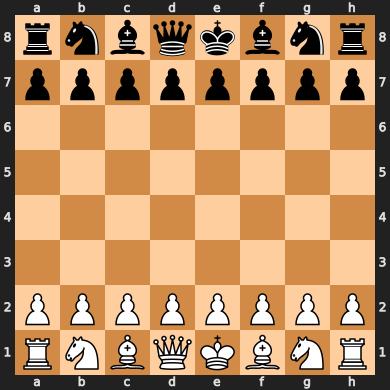

In [14]:
board = game_1.board()
board

In [15]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [16]:
moves = iter(game_1.mainline_moves())
moves

<generator object Mainline.__iter__ at 0x7f9f55bb3d80>

In [17]:
board_array = get_board_array(board)
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

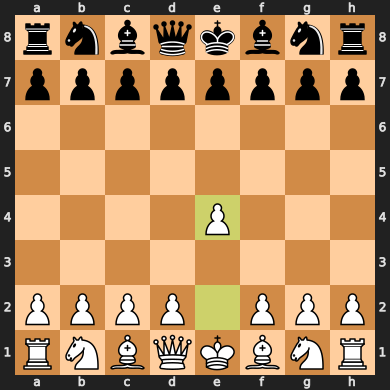

In [18]:
make_move(board, moves)
board

In [19]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


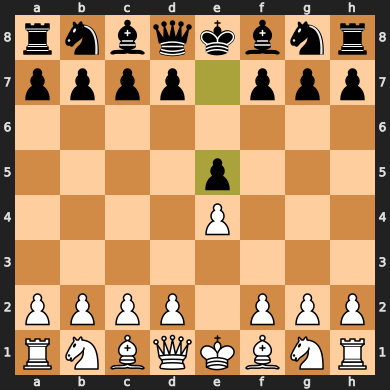

In [20]:
make_move(board, moves)
board

In [21]:
print(board)

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


In [22]:
board_array = get_board_array(board)
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

In [23]:
# TODO - Import from dao project in github package registry or maybe artifactory
class Player(Enum):
    WHITE = 1
    BLACK = -1

In [24]:
def get_players_turn_array(player: Player) -> np.ndarray:
    return np.full((8, 8), player.value)

In [25]:
white_players_turn = get_players_turn_array(Player.WHITE)
white_players_turn

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

In [26]:
black_players_turn = get_players_turn_array(Player.BLACK)
black_players_turn

array([[-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1]])

In [27]:
input_tensor = np.stack([board_array, black_players_turn], axis=0)
input_tensor

array([[[ 4,  2,  3,  5,  6,  3,  2,  4],
        [ 1,  1,  1,  1,  0,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1, -1, -1, -1,  0, -1, -1, -1],
        [-4, -2, -3, -5, -6, -3, -2, -4]],

       [[-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1]]])

In [28]:
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

In [29]:
FILES = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
RANKS = ['1', '2', '3', '4', '5', '6', '7', '8']
PROMOTION_PIECES = ['q', 'r', 'b', 'n']

In [30]:
def get_chess_board_layout():
    return ["".join(square) for square in itertools.product(FILES, RANKS)]

In [31]:
chess_board_layout = get_chess_board_layout()

In [32]:
def generate_standard_possible_moves():
    board_layout = get_chess_board_layout()

    return ["".join(move) for move in itertools.product(chess_board_layout, chess_board_layout)]

In [33]:
standard_possible_moves = generate_standard_possible_moves()

In [34]:
def generate_all_possible_white_promotion_moves():
    white_promotion_moves = []

    for file in FILES:
        for piece in PROMOTION_PIECES:
            white_promotion_moves.append(f"{file}7{file}8{piece}")

            for additional_file in FILES:
                if additional_file != file:
                    white_promotion_moves.append(f"{file}7{additional_file}8{piece}")

    return white_promotion_moves

In [35]:
white_promotion_moves = generate_all_possible_white_promotion_moves()

In [39]:
def generate_all_possible_black_promotion_moves():
    black_promotion_moves = []

    for file in FILES:
        for piece in PROMOTION_PIECES:
            black_promotion_moves.append(f"{file}2{file}1{piece}")

            for additional_file in FILES:
                if additional_file != file:
                    black_promotion_moves.append(f"{file}2{additional_file}1{piece}")

    return black_promotion_moves

In [40]:
black_promotion_moves = generate_all_possible_black_promotion_moves()

In [41]:
# a2b1q
white_promotion_moves
black_promotion_moves

['a2a1q',
 'a2b1q',
 'a2c1q',
 'a2d1q',
 'a2e1q',
 'a2f1q',
 'a2g1q',
 'a2h1q',
 'a2a1r',
 'a2b1r',
 'a2c1r',
 'a2d1r',
 'a2e1r',
 'a2f1r',
 'a2g1r',
 'a2h1r',
 'a2a1b',
 'a2b1b',
 'a2c1b',
 'a2d1b',
 'a2e1b',
 'a2f1b',
 'a2g1b',
 'a2h1b',
 'a2a1n',
 'a2b1n',
 'a2c1n',
 'a2d1n',
 'a2e1n',
 'a2f1n',
 'a2g1n',
 'a2h1n',
 'b2b1q',
 'b2a1q',
 'b2c1q',
 'b2d1q',
 'b2e1q',
 'b2f1q',
 'b2g1q',
 'b2h1q',
 'b2b1r',
 'b2a1r',
 'b2c1r',
 'b2d1r',
 'b2e1r',
 'b2f1r',
 'b2g1r',
 'b2h1r',
 'b2b1b',
 'b2a1b',
 'b2c1b',
 'b2d1b',
 'b2e1b',
 'b2f1b',
 'b2g1b',
 'b2h1b',
 'b2b1n',
 'b2a1n',
 'b2c1n',
 'b2d1n',
 'b2e1n',
 'b2f1n',
 'b2g1n',
 'b2h1n',
 'c2c1q',
 'c2a1q',
 'c2b1q',
 'c2d1q',
 'c2e1q',
 'c2f1q',
 'c2g1q',
 'c2h1q',
 'c2c1r',
 'c2a1r',
 'c2b1r',
 'c2d1r',
 'c2e1r',
 'c2f1r',
 'c2g1r',
 'c2h1r',
 'c2c1b',
 'c2a1b',
 'c2b1b',
 'c2d1b',
 'c2e1b',
 'c2f1b',
 'c2g1b',
 'c2h1b',
 'c2c1n',
 'c2a1n',
 'c2b1n',
 'c2d1n',
 'c2e1n',
 'c2f1n',
 'c2g1n',
 'c2h1n',
 'd2d1q',
 'd2a1q',
 'd2b1q',
 'd2c1q',


In [42]:
def generate_black_castling():
    castling = []
    castling.append("e8g8")  # Black kingside castling
    castling.append("e8c8")  # Black queenside castling

    return castling

In [43]:
def generate_white_castling():
    castling = []
    castling.append("e1g1")  # White kingside castling
    castling.append("e1c1")  # White queenside castling

    return castling

In [44]:
board.legal_moves

<LegalMoveGenerator at 0x7f9f57272830 (Nh3, Nf3, Ne2, Ba6, Bb5, Bc4, Bd3, Be2, Ke2, Qh5, Qg4, Qf3, Qe2, Nc3, Na3, h3, g3, f3, d3, c3, b3, a3, h4, g4, f4, d4, c4, b4, a4)>

In [45]:
legal_moves = list(board.legal_moves)

In [46]:
legal_uci_moves = [move.uci() for move in legal_moves]

In [47]:
def generate_all_possible_moves():
        running_moves = generate_standard_possible_moves()
        running_moves.extend(generate_all_possible_white_promotion_moves())
        running_moves.extend(generate_all_possible_black_promotion_moves())
        running_moves.extend(generate_black_castling())
        running_moves.extend(generate_white_castling())

        # En passant moves will be added dynamically during training due to the predicted move en passant move label
        # This is due in large part because this particular chess depends on the chess board state
        # and cannot be statically generated from possible moves for the possible move logits

        return running_moves

In [48]:
POSSIBLE_MOVES = generate_all_possible_moves()

In [49]:
def get_move_mask(board: Board) -> np.ndarray:
    move_mask = np.zeros(len(POSSIBLE_MOVES))
    possible_moves = generate_all_possible_moves()

    legal_moves = list(board.legal_moves)

    legal_uci_moves = [move.uci().lower() for move in legal_moves]

    for i, move in enumerate(possible_moves):
        if move in legal_uci_moves:
            move_mask[i] = 1

    return move_mask

In [50]:
PGN_COLUMN = "pgn"

In [51]:
class ChessDataset(Dataset):
    def __init__(self, games: List[str]):
        self.games = games

    def __len__(self):
        return len(self.games)

    def __getitem__(self, idx: int):
        try:

        # The line that might be causing the error (Accessing using index 154)
        # Example: data = self.df.loc[index, 154]  # Or something similar
        # ... your logic for getting boards, move_masks and movelabels...
          game = chess.pgn.read_game(io.StringIO(self.games[idx]))
        except KeyError:
          print(f"KeyError occurred for index: {idx}")
          print("Available columns/indices:", self.games[idx])  # Or self.df.index


        game = chess.pgn.read_game(io.StringIO(self.games[idx]))

        board = game.board()
        moves = list(game.mainline_moves())

        boards, move_masks, move_labels = [], [], []

        for move in moves:
            board_array = get_board_array(board)

            if board.turn:
                players_turn = get_players_turn_array(Player.WHITE)
            else:
                players_turn = get_players_turn_array(Player.BLACK)

            input_features = np.stack([board_array, players_turn], axis=0)

            move_mask = get_move_mask(board)
            move_label = POSSIBLE_MOVES.index(move.uci().lower())

            boards.append(input_features)
            move_masks.append(move_mask)
            move_labels.append(move_label)

            board.push(move)

        board_tensor = torch.tensor(boards, dtype=torch.float32)
        move_masks_tensor = torch.tensor(move_masks, dtype=torch.float32)
        move_labels_tensor = torch.tensor(move_labels, dtype=torch.long)


        return board_tensor, move_masks_tensor, move_labels_tensor

In [52]:
def padding_fn(batch):
    boards, move_masks, move_labels = zip(*batch)

    boards = pad_sequence(boards, batch_first=True, padding_value=0)
    move_masks = pad_sequence(move_masks, batch_first=True, padding_value=0)
    move_labels = pad_sequence(move_labels, batch_first=True, padding_value=-1)


    return boards, move_masks, move_labels

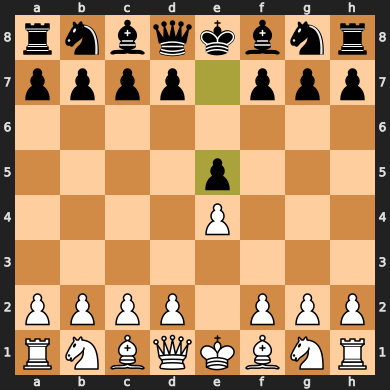

In [53]:
board

In [54]:
with open("possible_moves.txt", "w") as file:
    for move in POSSIBLE_MOVES:
        file.write(f"{move}\n")  # Write each item on a new line

In [55]:
pgn_games = all_games[PGN_COLUMN].tolist()

In [56]:
chess_dataset = ChessDataset(pgn_games)
chess_dataset

In [57]:
total_number_of_games = len(all_games)
total_number_of_games

105125

In [58]:
train_dataset_size = int(0.7 * total_number_of_games)
validation_dataset_size = int(0.15 * total_number_of_games)
test_dataset_size = total_number_of_games - train_dataset_size - validation_dataset_size

validation_dataset_size

In [59]:
train_dataset, validation_dataset, test_dataset = random_split(chess_dataset, [train_dataset_size, validation_dataset_size, test_dataset_size])

In [60]:
BATCH_SIZE = 32

In [61]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=padding_fn)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=padding_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=padding_fn)

In [62]:
len(train_loader)

2300

In [63]:
class ChessMoveModel(nn.Module):
    def __init__(self, number_of_possible_moves):
        super(ChessMoveModel, self).__init__()

        # Convulutional Layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=3, stride=1, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(8 * 8 * 2, 512)
        self.fc2 = nn.Linear(512, number_of_possible_moves)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1) # Flatten from (8, 8, 2) to (128,)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)           #  Output logits for the predicted move

        return x

In [72]:
num_possible_moves = len(POSSIBLE_MOVES)
model = ChessMoveModel(num_possible_moves)
model

ChessMoveModel(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4612, bias=True)
)

In [65]:
def calculate_accuracy(outputs, labels):
    predicated = outputs.argmax(-1)
    correct = (predicated == labels).sum().item()
    total = labels.size(0)

    return correct / total

In [66]:
EPOCHS = 5
LEARNING_RATE = 0.0001

# Assuming calculate_accuracy is defined elsewhere

def train_model(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        total_accuracy = []

        # Training loop
        for boards, move_masks, move_labels in train_loader:
            batch_size, sequence_length, channels, board_height, board_width = boards.size()
            num_possible_moves = move_masks.size(-1)

            # Reshape for model input
            boards = boards.view(batch_size * sequence_length, channels, board_height, board_width)
            move_masks = move_masks.view(batch_size * sequence_length, num_possible_moves)
            move_labels = move_labels.view(batch_size * sequence_length)

            # Forward pass
            outputs = model(boards)
            masked_output_moves = outputs * move_masks
            loss = criterion(masked_output_moves, move_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track accuracy for each batch
            accuracy = calculate_accuracy(outputs, move_labels)
            total_accuracy.append(accuracy)
            epoch_loss += loss.item()

        # Calculate average accuracy and loss for the epoch
        average_train_accuracy = np.mean(total_accuracy)
        average_train_loss = epoch_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0
        total_validation_accuracy = []

        with torch.no_grad():
            for val_boards, val_move_masks, val_move_labels in val_loader:
                batch_size, sequence_length, channels, board_height, board_width = val_boards.size()
                val_boards = val_boards.view(batch_size * sequence_length, channels, board_height, board_width)
                val_move_masks = val_move_masks.view(batch_size * sequence_length, num_possible_moves)
                val_move_labels = val_move_labels.view(batch_size * sequence_length)

                outputs = model(val_boards)
                masked_val_outputs = outputs * val_move_masks
                val_batch_loss = criterion(masked_val_outputs, val_move_labels)
                val_loss += val_batch_loss.item()

                # Track validation accuracy
                accuracy_val = calculate_accuracy(outputs, val_move_labels)
                total_validation_accuracy.append(accuracy_val)

        # Calculate average validation loss and accuracy
        average_val_accuracy = np.mean(total_validation_accuracy)
        average_val_loss = val_loss / len(val_loader)

        # Print training and validation metrics for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f}, "
              f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")



In [73]:
train_model(model, train_loader, val_loader, EPOCHS, LEARNING_RATE)
# drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/UNT/CSCE 5218/Semester Project/models/cnn.10.27.12.13.pytorch')

RuntimeError: The size of tensor a (8) must match the size of tensor b (0) at non-singleton dimension 3